A toy model of LSTM autoencoder, licensed under the [Apache License, Version 2.0](http://www.apache.org/licenses/LICENSE-2.0)

# Table of contents
* [Main libraries](#libraries)
* [Data preparation](#data)
* [LSTM autoencoder model](#LSTM)

<a id='libraries'></a>
# Main libraries
We start by importing the main libraires we shall use:

- the [numpy](https://numpy.org/) library (for arrays operations)
- the [seaborn](https://seaborn.pydata.org/) library (for statistical data visualization)
- the [matplotlib.pyplot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html) interface (for MATLAB-like plots)

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Setting as large the xtick and ytick font sizes in graphs
# Setting as 'darkgrid' the grid style in graphs

plt.rcParams['xtick.labelsize'] = 'large'
plt.rcParams['ytick.labelsize'] = 'large'

sns.set_style('darkgrid')

<a id='data'></a>
# Data preparation

In [3]:
# Defining a time series to play with (first 10 integers as time index and first 10 prime numbers as values)
# Setting as "features" the number of features of the time series (= 2 in this case)

series = np.array([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [2, 3, 5, 7, 11, 13, 17, 19, 23, 29]]).transpose()
features = series.shape[1]

print('\033[1m' + 'series.shape:' + '\033[0m' + '\n', series.shape, '\n')
print('\033[1m' + 'series:' + '\033[0m' + '\n', series)

series.shape:
 (10, 2) 

series:
 [[ 1  2]
 [ 2  3]
 [ 3  5]
 [ 4  7]
 [ 5 11]
 [ 6 13]
 [ 7 17]
 [ 8 19]
 [ 9 23]
 [10 29]]


We define a function "create_3D_array" which, given the time series "series" and the number of time steps "timesteps", creates a 3D numpy array "arr" suitable as input for the neural network. The 3D array has format:

$$
\hbox{(number of samples)} \times \hbox{(number of time steps)} \times \hbox{(number of features).}
$$

In [4]:
def create_3D_array(series, timesteps):
    arr = []
    for i in range(timesteps, series.shape[0]+1):
        arr.append(series[i-timesteps: i, :])
    return np.array(arr)

In [5]:
# Creating a 3D input array "input_arr" using the function function "create_3D_array"

timesteps = 6
input_arr = create_3D_array(series, timesteps)

print('\033[1m' + 'input_arr.shape:' + '\033[0m' + '\n', input_arr.shape, '\n')
print('\033[1m' + 'input_arr:' + '\033[0m' + '\n', input_arr)

input_arr.shape:
 (5, 6, 2) 

input_arr:
 [[[ 1  2]
  [ 2  3]
  [ 3  5]
  [ 4  7]
  [ 5 11]
  [ 6 13]]

 [[ 2  3]
  [ 3  5]
  [ 4  7]
  [ 5 11]
  [ 6 13]
  [ 7 17]]

 [[ 3  5]
  [ 4  7]
  [ 5 11]
  [ 6 13]
  [ 7 17]
  [ 8 19]]

 [[ 4  7]
  [ 5 11]
  [ 6 13]
  [ 7 17]
  [ 8 19]
  [ 9 23]]

 [[ 5 11]
  [ 6 13]
  [ 7 17]
  [ 8 19]
  [ 9 23]
  [10 29]]]


<a id='LSTM'></a>
# LSTM autoencoder model
First, we import the necessary classes from Keras:
- the [Sequential](https://keras.io/api/models/sequential/) class from the keras.models API (to group a linear stack of layers into a model)
- the [LSTM](https://keras.io/api/layers/recurrent_layers/lstm/) class from the keras.layers API (to apply a long short-term memory layer to an input)
- the [RepeatVector](https://keras.io/api/layers/reshaping_layers/repeat_vector/) class from the keras.layers API (to repeats an input various times)
- the [TimeDistributed](https://keras.io/api/layers/recurrent_layers/time_distributed/) class from the keras.layers API (to apply a layer to every temporal slice of an input)
- the [Dense](https://keras.io/api/layers/core_layers/dense/) class from the keras.layers API (to apply a regular densely-connected NN layer to an input)

In [6]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed

We define a LSTM autoencoder model which takes as input the 3D array containing the samples of the time series (format 5x6x2) and returns as output the encoded-and-decoded 3D array (format 5x6x2 again).

- Each sample of the input data has 6 timesteps and 2 features.
- Layer 1, LSTM(128), reads the input data and outputs a 2D array of size 6x128 (6 timesteps x 128 features due to option return_sequences=True).
- Layer 2, LSTM(64), reads the 6x128 output from layer 1 and reduces the feature size to 64. Since return_sequences=False, it outputs a feature vector of size 1x64, namely, the encoded feature vector of the input data.
- Layer 3, RepeatVector(timesteps), replicates the feature vector 6 (= timesteps) times. The RepeatVector layer acts as a bridge between the encoder and decoder modules. It prepares the 2D array input for the first LSTM layer of the decoder. The decoder module is designed to unfold the encoding, and thus has layers stacked in the reverse order of the encoder.
- Layers 4 and 5, LSTM (64) and LSTM (128), are the mirror images of layers 2 and 1, respectively.
- Layer 6, TimeDistributed(Dense(features)), creates a vector of length equal to the number of features outputted by the previous layer. Since layer 5 outputs 128 features, the TimeDistributed layer creates a vector of size 128x1 and replicates it 2 (= features) times. The output of layer 5 is a 6x128 array that we denote by U and that of layer 6 is a 128x2 array that we denote by V, so that a matrix multiplication between U and V yields a 6x2 array.

See this [post](https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352) for nice diagrams of LSTM autoencoder layers.

We use the rectified linear function "relu" as activation function for the LSTM layers. This helps the network to learn a compact representation of the input (with one or more true zero values). See this [post](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/) for more details.

In [7]:
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(timesteps, features), return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(RepeatVector(timesteps))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(features)))

We give a summary of the model using the [summary](https://keras.io/api/models/model/#summary-method) method of the model class of Keras. The "None" value stands for the (not yet defined) value of the batch size.

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 128)            67072     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 repeat_vector (RepeatVector  (None, 6, 64)            0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 6, 64)             33024     
                                                                 
 lstm_3 (LSTM)               (None, 6, 128)            98816     
                                                                 
 time_distributed (TimeDistr  (None, 6, 2)             258       
 ibuted)                                                

We import the [plot_model](https://keras.io/api/utils/model_plotting_utils/) function from the [keras.utils.vis_utils](https://faroit.com/keras-docs/2.0.8/visualization/) module to plot a schema of the model.

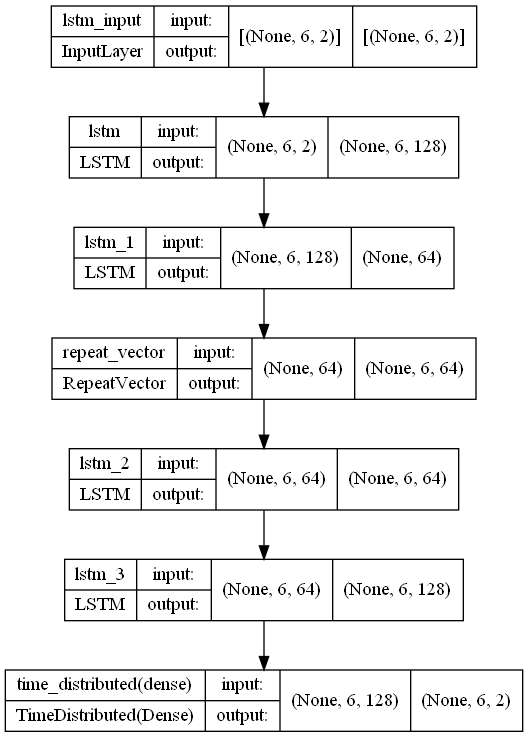

In [9]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True)

We configure (compile) the model for training with the following parameters:

- [adam](https://keras.io/api/optimizers/adam) as optimizer to use during training process (a combination of gradient descent with momentum and RMSP)
- [mean square error](https://keras.io/api/losses/regression_losses/#meansquarederror-class) (mse) between labels and predictions as quantity to minimise during training process
- [root mean absolute error](https://keras.io/api/metrics/regression_metrics/#rootmeansquarederror-class) between labels and predictions as metric to display during training process

In [10]:
model.compile(optimizer='adam', loss='mse', metrics='RootMeanSquaredError')

We [train the model](https://keras.io/api/models/model_training_apis/#fit-method) with a given input array, output array, batch size and number of epochs. The objective of training is to make the output array as close as possible to the input array.

An epoch is a pass of the neural network over the entire training set and the batch size is the number of samples that are passed to the network at once (the default batch size in Keras is 32). For each epoch, we thus have

$$
\hbox{number of training steps} = \frac{\hbox{length of training set}}{\hbox{batch size}}\;\!.
$$

In [11]:
batch_size = 2
epochs = 1000
history = model.fit(input_arr, input_arr, batch_size=batch_size, epochs=epochs, verbose=0)

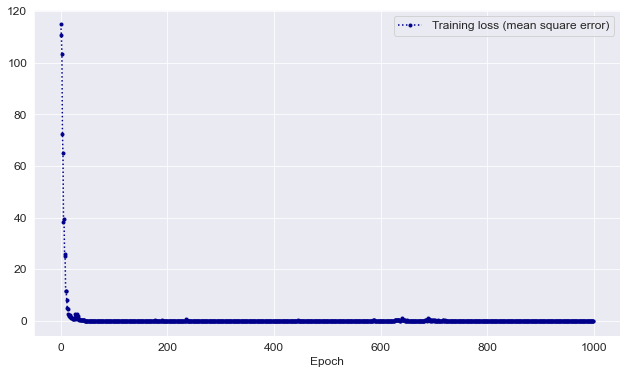

In [14]:
# Plot of the training loss vs. number of epoch

_, p = plt.subplots(figsize=(10.5,6))
p.plot(history.history['loss'], color='darkblue', linestyle='dotted', marker='.', label='Training loss (mean square error)')

# Parameters of the plot

p.set_xlabel('Epoch', size='large')
p.legend(fontsize='large')
p.grid(True)

In [13]:
# Storing in numpy array "output_arr" the reconstructed version of "output_arr" and printing it

output_arr = model.predict(input_arr)

print('\033[1m' + 'output_arr:' + '\033[0m' + '\n', np.round(output_arr, 2), '\n')
print('\033[1m' + 'input_arr:' + '\033[0m' + '\n', input_arr)

output_arr:
 [[[ 1.07  1.97]
  [ 1.98  3.  ]
  [ 3.01  5.  ]
  [ 3.99  7.  ]
  [ 5.01 11.  ]
  [ 6.   13.  ]]

 [[ 1.88  3.08]
  [ 3.03  4.99]
  [ 4.    7.  ]
  [ 5.   11.  ]
  [ 6.   13.  ]
  [ 7.   17.  ]]

 [[ 3.04  4.95]
  [ 3.99  7.  ]
  [ 5.   11.  ]
  [ 6.   13.  ]
  [ 7.   17.  ]
  [ 8.   19.  ]]

 [[ 4.01  7.02]
  [ 5.01 11.01]
  [ 6.   13.  ]
  [ 7.   17.  ]
  [ 8.   19.  ]
  [ 9.   23.  ]]

 [[ 5.   11.  ]
  [ 6.   13.  ]
  [ 7.   17.  ]
  [ 8.   19.  ]
  [ 9.   23.  ]
  [10.   29.  ]]] 

input_arr:
 [[[ 1  2]
  [ 2  3]
  [ 3  5]
  [ 4  7]
  [ 5 11]
  [ 6 13]]

 [[ 2  3]
  [ 3  5]
  [ 4  7]
  [ 5 11]
  [ 6 13]
  [ 7 17]]

 [[ 3  5]
  [ 4  7]
  [ 5 11]
  [ 6 13]
  [ 7 17]
  [ 8 19]]

 [[ 4  7]
  [ 5 11]
  [ 6 13]
  [ 7 17]
  [ 8 19]
  [ 9 23]]

 [[ 5 11]
  [ 6 13]
  [ 7 17]
  [ 8 19]
  [ 9 23]
  [10 29]]]


**¡¡Thank you for reading!!**